## Instalar pacotes necessários

In [1]:
!pip install optuna
!pip install category_encoders
!pip install catboost

## 1.0 Importar bibliotecas

In [2]:
import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
import optuna
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB


## 2.0 Funções auxiliares

In [3]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

## 3.0 Leitura dos dados

In [4]:
df_train = pd.read_csv('../df_treino_vars_selected.csv')
df_test = pd.read_csv('../df_teste_vars_selected.csv')

In [5]:
df_train.head()

,Unnamed: 0,Idade,Limite_Credito_Mercado,Qte_Categorias,Estado,ClientId,Target
0,9254,32,0.0000,2,São Paulo,354822,0
1,1561,42,1196.2460,2,Minas Gerais,347129,0
2,1670,24,1147.3992,1,Rio de Janeiro,347238,1
3,6087,27,1356.3700,1,São Paulo,351655,1
4,6669,56,1421.4732,1,São Paulo,352237,1


In [6]:
df_test.head()

,Unnamed: 0,Idade,Limite_Credito_Mercado,Qte_Categorias,Estado,ClientId
0,6252,32,967.0907,2,Minas Gerais,351820
1,4684,43,0.0000,2,São Paulo,350252
2,1731,44,0.0000,2,Rio de Janeiro,347299
3,4742,59,1191.5210,2,Minas Gerais,350310
4,4521,27,1249.9598,1,Rio de Janeiro,350089


## 4.0 Preparação dos dados

In [7]:
df_test.drop(columns=['ClientId','Unnamed: 0'],inplace=True)

X = df_train.drop(columns=['ClientId','Target', 'Unnamed: 0'])
y = df_train['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ------ Ideias de feature engineering ----------#

# ----------------------------------------------- TREINO
# AMT_CREDIT
X_train['Limit_per_Age'] = X_train['Limite_Credito_Mercado']/X_train['Idade']
X_train['Limit_per_Qtd_Category'] = X_train['Limite_Credito_Mercado']/X_train['Qte_Categorias']
X_train['Age_per_Qtd_Category'] = X_train['Idade']/X_train['Qte_Categorias']


# ----------------------------------------------- TESTE
# AMT_CREDIT
X_test['Limit_per_Age'] = X_test['Limite_Credito_Mercado']/X_test['Idade']
X_test['Limit_per_Qtd_Category'] = X_test['Limite_Credito_Mercado']/X_test['Qte_Categorias']
X_test['Age_per_Qtd_Category'] = X_test['Idade']/X_test['Qte_Categorias']


# ----------------------------------------------- BASE DE ESCORAGEM
# AMT_CREDIT
df_test['Limit_per_Age'] = df_test['Limite_Credito_Mercado']/df_test['Idade']
df_test['Limit_per_Qtd_Category'] = df_test['Limite_Credito_Mercado']/df_test['Qte_Categorias']
df_test['Age_per_Qtd_Category'] = df_test['Idade']/df_test['Qte_Categorias']



cat_attributes = X_train.select_dtypes(include='object')
num_attributes = X_train.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])


X_train_processed = pd.DataFrame(preprocesssor.fit_transform(X_train, y_train),columns=X_train.columns)
X_test_processed = pd.DataFrame(preprocesssor.transform(X_test),columns=X_test.columns)

X_prod_processed = pd.DataFrame(preprocesssor.transform(df_test),columns=df_test.columns)

## 5.0 Testar algoritmos

In [8]:
# Testar outros modelos

algoritmos = [DecisionTreeClassifier(criterion='gini',random_state=0),
            LogisticRegression(solver='liblinear',random_state=0),
            RandomForestClassifier(random_state=0),
            GradientBoostingClassifier(random_state=0),
            XGBClassifier(random_state=0),
            lgb.LGBMClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.971562,0.965174,0.892638,0.994935,0.989869,0.919216
1,DecisionTreeClassifier,Teste,0.805000,0.514469,0.498442,0.688706,0.377412,0.409030


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.810469,0.589041,0.230828,0.799178,0.598356,0.461973
1,LogisticRegression,Teste,0.810000,0.575221,0.202492,0.795730,0.591459,0.456604


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.971562,0.957586,0.900307,0.985984,0.971969,0.906613
1,RandomForestClassifier,Teste,0.831875,0.606557,0.461059,0.804243,0.608485,0.497358


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.865938,0.768675,0.489264,0.878477,0.756955,0.593653
1,GradientBoostingClassifier,Teste,0.847500,0.685990,0.442368,0.845902,0.691803,0.573969


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.911563,0.878074,0.657209,0.954035,0.908070,0.780548
1,XGBClassifier,Teste,0.837500,0.644550,0.423676,0.826611,0.653222,0.538870


[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.887500,0.832574,0.560583,0.931355,0.862710,0.708376
1,LGBMClassifier,Teste,0.845625,0.683168,0.429907,0.836922,0.673845,0.566968


In [9]:
# Save the pipeline to a file
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)


In [10]:
with open('vars_gb.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

## 6.0 Tunagem de hiperparâmetros

In [11]:
import optuna

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [12]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):

    """param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }"""

    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Feature fraction
    }    

    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
    avg_roc = 0
    for tr, ts in cv.split(X_train, y_train):
        Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        model = GradientBoostingClassifier(**param,random_state = 0)
        Xtr_processed = pd.DataFrame(preprocesssor.fit_transform(Xtr, ytr),columns=X_train.columns)
        Xvl_processed = pd.DataFrame(preprocesssor.transform(Xvl),columns=X_test.columns)
        model.fit(Xtr_processed,ytr)
        p = model.predict_proba(Xvl_processed)[:, 1]
        avg_roc += roc_auc_score(yvl, p)

    return avg_roc/5

study = optuna.create_study(direction="maximize",study_name="modelo8", storage="sqlite:///modelo.db")
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    study = optuna.load_study(study_name="modelo8", storage="sqlite:///modelo.db")
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-28 15:14:09,531] A new study created in RDB with name: modelo8
[I 2024-04-28 15:14:12,928] Trial 0 finished with value: 0.8360510614035208 and parameters: {'learning_rate': 0.015086328385329957, 'n_estimators': 139, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8829528059196112}. Best is trial 0 with value: 0.8360510614035208.
[I 2024-04-28 15:14:16,710] Trial 1 finished with value: 0.8399293227655151 and parameters: {'learning_rate': 0.10226543351018079, 'n_estimators': 168, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 7, 'subsample': 0.5342521728742511}. Best is trial 1 with value: 0.8399293227655151.
[I 2024-04-28 15:14:23,799] Trial 2 finished with value: 0.8248998157678814 and parameters: {'learning_rate': 0.16412446141160092, 'n_estimators': 245, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 5, 'subsample': 0.8448666661000683}. Best is trial 1 with value: 0.8399293227655151.
[I 2024-04-28 15:14:44,765] Tria

EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.843546012284682
  Params: 
    learning_rate: 0.03950339164458459
    n_estimators: 55
    max_depth: 8
    min_samples_split: 20
    min_samples_leaf: 7
    subsample: 0.6604073264252752


In [13]:
algoritmo = GradientBoostingClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.879687,0.847656,0.499233,0.911355,0.822710,0.653903
1,GradientBoostingClassifier,Teste,0.851250,0.731844,0.408100,0.842920,0.685841,0.574653


## 7.0 Ordenação nos decis

### Treino

In [14]:
y_train.index = X_train_processed.index

bins = 3
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['Target']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='Target', aggfunc='mean'),
    volume=pd.NamedAgg(column='Target', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='Target', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='Target', aggfunc=lambda x: (x == 1).sum()/tab[tab.Target == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

C:\Users\jeanr\AppData\Local\Temp\ipykernel_17016\36904822.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.518744,0.848926
1,1,0.080638,0.131902
2,2,0.011721,0.019172


### Teste

In [15]:
y_test.index = X_test_processed.index

bins = 3
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['Target']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='Target', aggfunc='mean'),
    volume=pd.NamedAgg(column='Target', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='Target', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='Target', aggfunc=lambda x: (x == 1).sum()/tab[tab.Target == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

C:\Users\jeanr\AppData\Local\Temp\ipykernel_17016\3967197310.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.474672,0.788162
1,1,0.089888,0.149533
2,2,0.037523,0.062305


In [16]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.518744,0.848926,0.474672,0.788162
1,1,0.080638,0.131902,0.089888,0.149533
2,2,0.011721,0.019172,0.037523,0.062305


### Visualização Gráfica

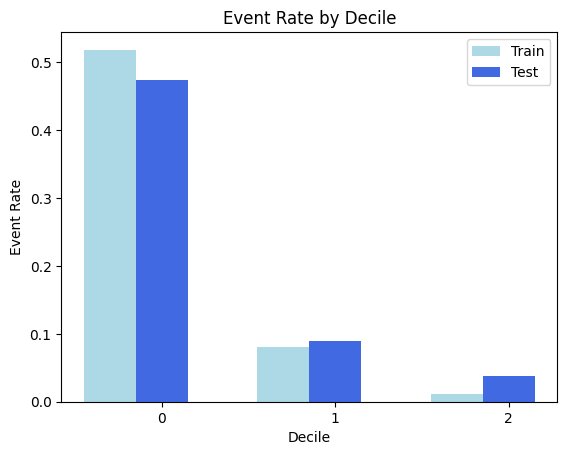

In [17]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

## Escoragem

In [18]:
df_test = pd.read_csv('../df_teste_vars_selected.csv')
y_predict_proba_prod = algoritmo.predict_proba(X_prod_processed)[:,1]
df_submission_test = pd.DataFrame(df_test.ClientId.values,columns=['ID'])
df_submission_test['TARGET'] = y_predict_proba_prod

df_submission_test.to_csv('submission_test.csv', index=False)

## Salvar melhor modelo

In [19]:
import pickle

with open('gb.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)

## Importando melhor modelo

In [20]:
import pickle

# Load the pipeline from the file
with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Load the feature names
with open('vars_gb.pkl', 'rb') as f:
    features = pickle.load(f)
    # Adicionar as novas características à lista de features
    #features = list(features)  # Converta o Index em uma lista para poder usar o método extend
    #features.extend(['Limit_per_Age', 'Limit_per_Qtd_Category', 'Age_per_Qtd_Category'])

# Load the trained model
with open('gb.pkl', 'rb') as file:
    model = pickle.load(file)


In [89]:
df = pd.read_csv('../db_churn_2.csv')
df.columns


Index(['Unnamed: 0', 'ClientId', 'DataExtracao', 'Score_Credito', 'Estado',
       'Gênero', 'Idade', 'Tempo_Cliente', 'Limite_Credito_Mercado',
       'Qte_Categorias', 'Usa_Cartao_Credito', 'Programa_Fidelidade',
       'Sum_Pedidos_Acumulados', 'DataUltimaTransacao',
       'DiasDesdeUltTransacao', 'Target'],
      dtype='object')

In [90]:
df['Limit_per_Age'] = df['Limite_Credito_Mercado']/df['Idade']
df['Limit_per_Qtd_Category'] = df['Limite_Credito_Mercado']/df['Qte_Categorias']
df['Age_per_Qtd_Category'] = df['Idade']/df['Qte_Categorias']

In [91]:
df.columns

Index(['Unnamed: 0', 'ClientId', 'DataExtracao', 'Score_Credito', 'Estado',
       'Gênero', 'Idade', 'Tempo_Cliente', 'Limite_Credito_Mercado',
       'Qte_Categorias', 'Usa_Cartao_Credito', 'Programa_Fidelidade',
       'Sum_Pedidos_Acumulados', 'DataUltimaTransacao',
       'DiasDesdeUltTransacao', 'Target', 'Limit_per_Age',
       'Limit_per_Qtd_Category', 'Age_per_Qtd_Category'],
      dtype='object')

In [92]:
# Fazer uma cópia do DataFrame original antes de selecionar as características
df_original = df.copy()

# Selecionar apenas as características relevantes
df = df[features]

# Recuperar a coluna "ClientId" do DataFrame original
df['ClientId'] = df_original['ClientId']

# Verificar o DataFrame resultante
df.columns

Index(['Idade', 'Limite_Credito_Mercado', 'Qte_Categorias', 'Estado',
       'Limit_per_Age', 'Limit_per_Qtd_Category', 'Age_per_Qtd_Category',
       'ClientId'],
      dtype='object')

In [93]:
# 1. Pré-processamento dos dados
# Remover a coluna 'ClientId' do DataFrame df
df.drop('ClientId', axis=1, inplace=True)
X_processed = pd.DataFrame(preprocessor.transform(df), columns=df.columns)

y_predict_proba_prod = algoritmo.predict_proba(X_processed)[:,1]
df_submission_full = pd.DataFrame(df_original.ClientId.values,columns=['ID'])
df_submission_full['TARGET'] = y_predict_proba_prod

df_submission_full.to_csv('df_submission_full.csv', index=False)
